In [6]:
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import gamma
import numpy as np
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

notebook_folder = os.path.abspath('')

In [62]:
def combine_decade_GISS(base_folder, start_year, end_year):
    all_prec_values = []
    month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            month_str = month_names[month - 1]
            folder_path = os.path.join(base_folder, str(year))
            file_path = os.path.join(folder_path, f'{month_str}{year}.aijh12iWISO_20th_MERRA2_ANL.nc')
            #print(file_path)
            if os.path.exists(file_path):  # Check if the file exists
                #print(file_path)
                dataset = nc.Dataset(file_path)
                prec = dataset.variables['prec'][:, :, :]
                all_prec_values.extend(prec.flatten())

    all_prec_values = np.array(all_prec_values)
    return all_prec_values

def combine_decade_IMERG(base_folder, start_year, end_year):
    all_prec_values = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            folder_path = os.path.join(base_folder, str(year), 'global')
            month_str = f'{month:02d}'  # Format month as a 2-digit string
            file_name = f'{year}_{month_str}_global_precipitation.npz'
            file_path = os.path.join(folder_path, file_name)
            if os.path.exists(file_path):  # Check if the file exists
                data = np.load(file_path)
                prec = data['all_values']
                
                all_prec_values.extend(prec.flatten())
                
    all_prec_values = np.array(all_prec_values)
    # Remove NaN values
    all_prec_values = all_prec_values[~np.isnan(all_prec_values)]
    return all_prec_values

In [35]:
base_folder = os.path.join('/Users/lilydonaldson/Downloads/examples/data/GISS/GISS_subdaily')
start_year = 2011
end_year = 2020

GISS_data = combine_decade_GISS(base_folder, start_year, end_year)
print(len(GISS_data))
with open(f'/Users/lilydonaldson/Downloads/examples/data/GISS/GISS_pickles/GISS_data_{start_year}-{end_year}.pkl', 'wb') as f:
    pickle.dump(GISS_data, f)

189216000


In [63]:
base_folder = os.path.join('/Users/lilydonaldson/Downloads/examples/data/IMERG/IMERG_automated')
start_year = 2011
end_year = 2020
IMERG_data = combine_decade_IMERG(base_folder, start_year, end_year)
print(len(IMERG_data))
with open('/Users/lilydonaldson/Downloads/examples/data/IMERG/IMERG_pickles/IMERG_data_{start_year}-{end_year}.pkl', 'wb') as f:
    pickle.dump(IMERG_data, f)

185950080


In [64]:
def histogramPrec(giss_data, imerg_data, title, output_path):
    # Calculate statistics
    giss_avg, giss_95th, giss_99th = np.mean(giss_data), np.percentile(giss_data, 95), np.percentile(giss_data, 99)
    imerg_avg, imerg_95th, imerg_99th = np.mean(imerg_data), np.percentile(imerg_data, 95), np.percentile(imerg_data, 99)

    # Determine combined bins
    combined_min =  min(np.min(giss_data), np.min(imerg_data))
    combined_max = max(np.max(giss_data), np.max(imerg_data))
    bins = np.linspace(combined_min, combined_max, 50)  # 50 bins

    # Plot histograms with the same bins
    plt.hist(imerg_data, bins=bins, log=True, density=True, alpha=0.5, color='blue', label='IMERG')
    plt.hist(giss_data, bins=bins, log=True, density=True, alpha=0.5, color='red', label='GISS')

    # Add percentile lines with labels for the legend
    plt.axvline(x=giss_99th, color='red', linestyle='dotted', label='GISS 99th percentile')
    plt.axvline(x=imerg_99th, color='blue', linestyle='dotted', label='IMERG 99th percentile')

    # Plot settings
    title = "GISS vs IMERG Precipitation | " + title
    plt.title(title)
    plt.xlabel('Precipitation (mm/day)')
    plt.ylabel('Density (log scale)')
    plt.legend()

    #plt.xlim(0, combined_max)

    # Add average text on the right side of the plot
    plt.text(0.66, 0.53, f'GISS Avg: {giss_avg:.2f}\nIMERG Avg: {imerg_avg:.2f}\n\nGISS 95th %: {giss_95th:.2f}\nIMERG 95th %: {imerg_95th:.2f}\n\nGISS 99th %: {giss_99th:.2f}\nIMERG 99th %: {imerg_99th:.2f}', 
             horizontalalignment='left', verticalalignment='center', 
             transform=plt.gca().transAxes, color='black', fontsize=7)

    # Show plot for visualization in this context
    plt.show()

    plt.savefig(output_path, dpi=300)
    print(f"Saved plot to {output_path}.")
    plt.close()

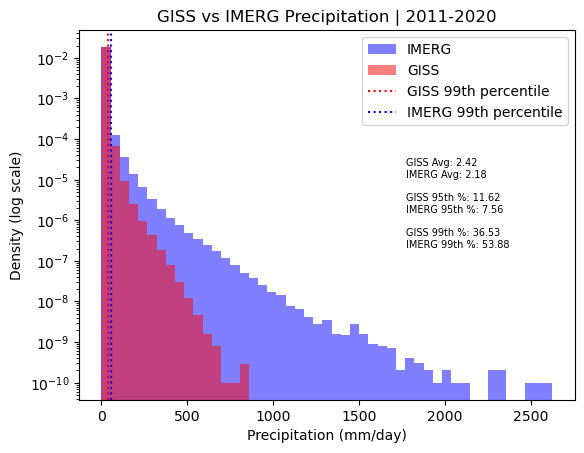

Saved plot to /Users/lilydonaldson/Desktop.


In [65]:
histogramPrec(GISS_data, IMERG_data, f"{start_year}-{end_year}", "/Users/lilydonaldson/Desktop")